<a href="https://colab.research.google.com/github/ivanpalenciab/prediccion-precio-maiz/blob/Primera_fase/4_XGboost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb

from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing

In [ ]:

#Este diccionario almacenara el rendimiento de cada uno de los modelos que se estaran provando
rendimiento={}

In [ ]:
data = pd.read_csv("/content/drive/MyDrive/prediccion_productos_agro/EWT_datos.csv")
data["Fecha"] = pd.to_datetime(data["Fecha"],format='%Y-%m-%d')
data.set_index("Fecha", inplace=True)
data.head(5)

,Precio_Cierre
Fecha,
2021-06-29,447.793013
2021-06-28,455.382649
2021-06-25,462.933295
2021-06-24,470.424338
2021-06-23,477.835301


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10454 entries, 2021-06-29 to 1980-01-02
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Precio_Cierre  10454 non-null  float64
dtypes: float64(1)
memory usage: 163.3 KB


In [ ]:
data = data.asfreq('D')
data.interpolate(inplace=True)

<Axes: xlabel='Fecha'>

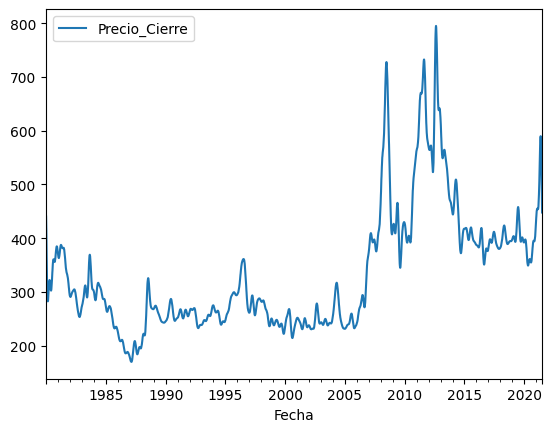

In [ ]:
data.plot()

In [ ]:
def  create_features ( df ):
    """
    Crea características de series de tiempo basadas en el índice de series de tiempo.
    """
    df = df.copy()
    df[ 'diasemana' ] = df.index.dayofweek
    df[ 'trimestre' ] = df.index.quarter
    df[ 'mes' ] = df.index.month
    df[ 'año' ] = df.index.year
    df[ 'diadelaño' ] = df.index.dayofyear
    df[ 'diadelmes' ] = df.index.day
    df[ 'semanadelaño' ] = df.index.isocalendar().week
    return df

data = create_features(data)

#agregar características de retraso al conjunto de datos
def add_lags(df):
    target_map = df['Precio_Cierre'].to_dict()
    df['lag1'] = (df.index - pd.Timedelta('365 days')).map(target_map)
    df['lag2'] = (df.index - pd.Timedelta('730 days')).map(target_map)
    df['lag3'] = (df.index - pd.Timedelta('1095 days')).map(target_map)
    return df

data = add_lags(data)

data.tail()

,Precio_Cierre,diasemana,trimestre,mes,año,diadelaño,diadelmes,semanadelaño,lag1,lag2,lag3
Fecha,,,,,,,,,,,
2021-06-25,462.933295,4,2,6,2021,176,25,25,360.349589,457.895097,399.921155
2021-06-26,460.416413,5,2,6,2021,177,26,25,360.080707,457.962755,399.234673
2021-06-27,457.899531,6,2,6,2021,178,27,25,359.982895,457.918210,398.566333
2021-06-28,455.382649,0,2,6,2021,179,28,26,359.885083,457.865962,397.917166
2021-06-29,447.793013,1,2,6,2021,180,29,26,359.787272,457.813714,397.707481


In [ ]:
data = data.dropna()
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 14060 entries, 1983-01-01 to 2021-06-29
Freq: D
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Precio_Cierre  14060 non-null  float64
 1   diasemana      14060 non-null  int64  
 2   trimestre      14060 non-null  int64  
 3   mes            14060 non-null  int64  
 4   año            14060 non-null  int64  
 5   diadelaño      14060 non-null  int64  
 6   diadelmes      14060 non-null  int64  
 7   semanadelaño   14060 non-null  UInt32 
 8   lag1           14060 non-null  float64
 9   lag2           14060 non-null  float64
 10  lag3           14060 non-null  float64
dtypes: UInt32(1), float64(4), int64(6)
memory usage: 1.2 MB


In [ ]:
total_datos=len(data.Precio_Cierre)
porcentaje_entrenamiento, porcentaje_validacion = 0.8,0.1
division_entrenamiento = int(total_datos*porcentaje_entrenamiento)
division_validacion = division_entrenamiento + int(porcentaje_validacion*total_datos)
print(division_validacion)
print(division_entrenamiento,division_validacion)

datos_entrenamiento = data[:division_entrenamiento]
datos_validacion = data[division_entrenamiento:division_validacion]
datos_testeo = data[division_validacion:total_datos]

12654
11248 12654


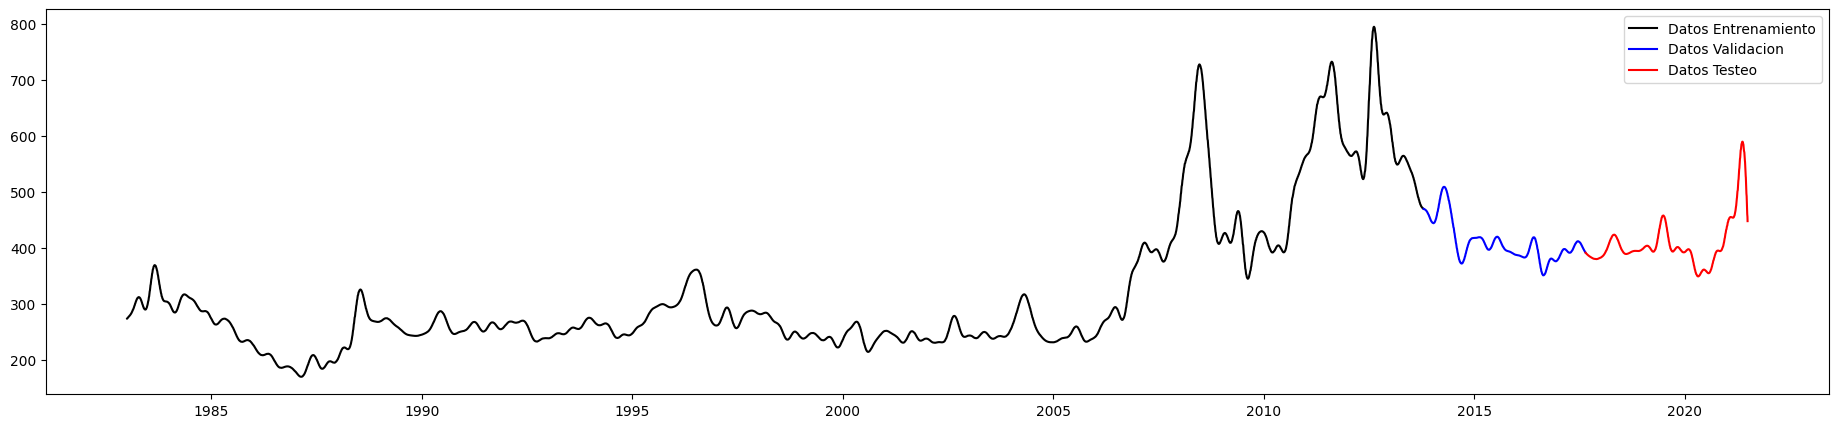

In [ ]:
fig, ax = plt.subplots(figsize=(23, 5))
ax.plot(datos_entrenamiento.index,datos_entrenamiento.Precio_Cierre,color='black',label = 'Datos Entrenamiento')
ax.plot(datos_validacion.index,datos_validacion.Precio_Cierre,color='blue',label = 'Datos Validacion')
ax.plot(datos_testeo.index,datos_testeo.Precio_Cierre,color='red',label = 'Datos Testeo')
ax.legend(loc = 'upper right')
plt.show()

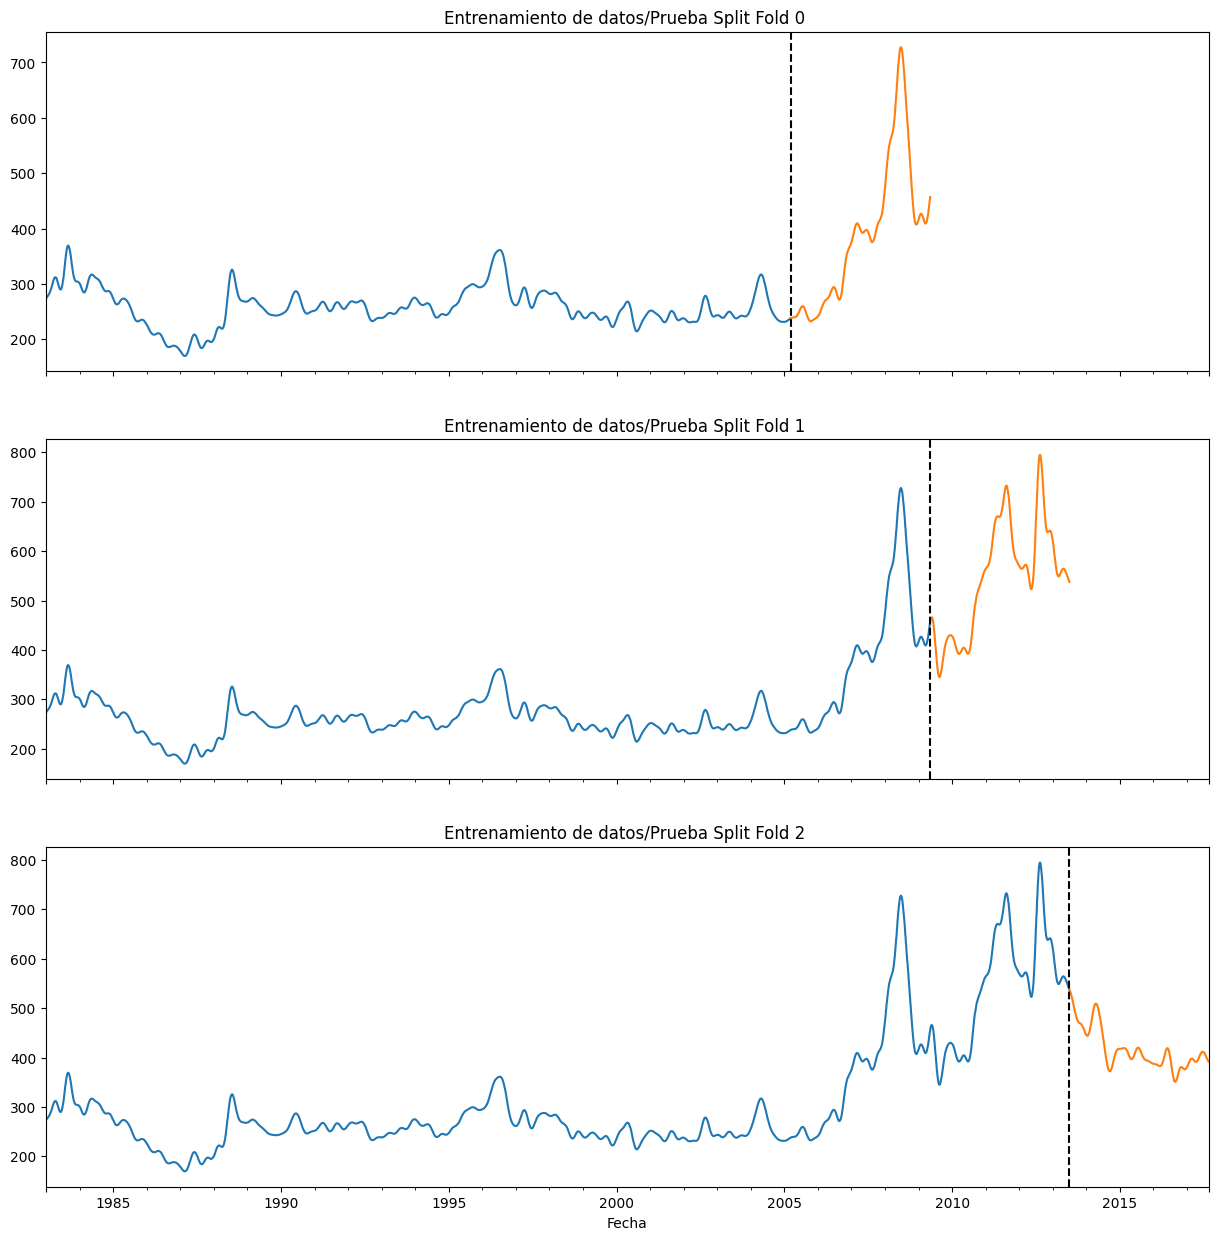

In [ ]:
#configurar el modelo dividido de series temporales
tss = TimeSeriesSplit(n_splits= 3 , test_size= 1515 , gap= 1 )


#ilustra cómo se entrenarán los datos con múltiples pliegues
fig, axs = plt.subplots( 3 , 1 , figsize=( 15 , 15 ), sharex= True )


fold = 0
for train_idx, val_idx in tss.split(data[:division_validacion]):
    train = data.iloc[train_idx]
    test = data.iloc[val_idx]
    train[ 'Precio_Cierre' ].plot(ax=axs[fold],
                          label= 'Conjunto de entrenamiento' ,
                          title= f'Entrenamiento de datos/Prueba Split Fold {fold} ' )
    test[ 'Precio_Cierre' ].plot(ax=axs[fold],
                         label= 'Conjunto de prueba' )
    axs[fold].axvline(test.index. min (), color= 'black' , ls= '--' )
    fold += 1
plt.show()

In [ ]:
data.sample(10)

,Precio_Cierre,diasemana,trimestre,mes,año,diadelaño,diadelmes,semanadelaño,lag1,lag2,lag3
Fecha,,,,,,,,,,,
2003-09-28,242.679921,6,3,9,2003,271,28,39,264.812668,243.181710,229.365705
1994-07-25,244.791698,0,3,7,1994,206,25,30,257.144265,251.161578,258.486691
2004-03-25,309.382044,3,1,3,2004,85,25,13,241.375919,231.115574,244.129555
1995-07-13,293.287951,3,3,7,1995,194,13,28,249.317447,255.345466,257.965703
1996-06-18,359.795859,1,2,6,1996,170,18,25,289.416433,258.886949,250.344915
1987-02-10,170.340262,1,1,2,1987,41,10,7,213.598654,263.033983,285.128914
1998-03-14,283.703557,5,1,3,1998,73,14,11,289.865826,317.523405,261.511386
2016-04-23,398.598351,5,2,4,2016,114,23,16,398.303325,507.370395,564.481700
1989-04-21,266.270472,4,2,4,1989,111,21,16,226.040776,193.095814,210.295234


In [ ]:
#vamos a buscar los mejores hiperparametros para el modelo

#Modelo
model = xgb.XGBRegressor()

#Parametros a probar
param_grid = {
    #'n_estimators': [500,1000 ,1500],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5, verbose=1)
grid_search.fit(datos_entrenamiento[ ['diasemana' , 'trimestre' , 'mes' , 'año' ,'diadelaño','diadelmes','semanadelaño','lag1' , 'lag2' , 'lag3'] ], datos_entrenamiento.Precio_Cierre)

Fitting 5 folds for each of 81 candidates, totalling 405 fits


GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             param_grid={'colsample_bytree': [0.8, 0.9, 1.0],
                         'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 4, 5], 'subsample': [0.8, 0.9, 1.0]},
             scoring='neg_mean_squared_error', verbose=1)

In [ ]:
#ejecutando el modelo de aprendizaje automático
tss = TimeSeriesSplit(n_splits= 3 , test_size= 365 , gap= 1 )
data = data.sort_index()


fold = 0
preds = []
puntuaciones = []
mapes = []
maes =[]
for train_idx, val_idx in tss.split(data[:division_validacion]) :
    train = data.iloc[train_idx]
    test = data.iloc[val_idx]

    train = create_features(train)
    test = create_features(test)

    CARACTERISTICAS = [ 'diasemana' , 'trimestre' , 'mes' , 'año' ,'diadelaño','diadelmes','semanadelaño',
                'lag1' , 'lag2' , 'lag3' ]
    OBJETIVO = 'Precio_Cierre'

    X_train = train[CARACTERISTICAS]
    y_train = train[OBJETIVO]

    X_test = test[CARACTERISTICAS]
    y_test = test[OBJETIVO]

    reg = xgb.XGBRegressor( base_score= None , booster= None ,
                           n_estimators= 1000 ,
                           early_stopping_rounds= 50 ,
                           Objective= 'reg:squarederror' ,
                           max_depth= 4 ,
                           learning_rate= 0.1 )
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)

    y_pred = reg.predict(X_test)
    y_pred = pd.Series(y_pred)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_pred,y_test))
    mae = mean_absolute_error(y_pred,y_test)
    mape = mean_absolute_percentage_error(y_pred,y_test)
    puntuaciones.append(score)
    mapes.append(mape)
    maes.append(mae)

rendimiento["EWT"] = {"RECM":np.mean(puntuaciones),
 "EAM":np.mean(maes) ,
 "PEAM":np.mean(mapes)}

#imprimir puntuaciones para cada pliegue
print ( f'Puntuación entre pliegues {np.mean(puntuaciones)} ' )
print ( f'Puntuaciones plegar: {puntuaciones} ' )
print(f"Error Absoluto medio entre pliegues {np.mean(maes)}")
print(f"porcentaje de error absoluto medio entre pliegues{np.mean(mapes)}")

[0]	validation_0-rmse:113.43074	validation_1-rmse:72.88640
[56]	validation_0-rmse:13.33715	validation_1-rmse:73.14457
[0]	validation_0-rmse:112.54537	validation_1-rmse:59.41075
[55]	validation_0-rmse:13.40116	validation_1-rmse:64.65437


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [15:19:47] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "Objective" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [15:19:47] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "Objective" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-rmse:111.69060	validation_1-rmse:62.41176
[72]	validation_0-rmse:12.15596	validation_1-rmse:19.37683
Puntuación entre pliegues 15.526074463467284 
Puntuaciones plegar: [14.961578385534002, 16.610990549228287, 15.005654455639563] 
Error Absoluto medio entre pliegues 12.76968690845932
porcentaje de error absoluto medio entre pliegues0.03287864207922958


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [15:19:47] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "Objective" } are not used.

  warnings.warn(smsg, UserWarning)


In [ ]:
rendimiento

{'EWT': {'RECM': 15.526074463467284,
  'EAM': 12.76968690845932,
  'PEAM': 0.03287864207922958}}

In [ ]:
CARACTERISTICAS =[ 'diasemana' , 'trimestre' , 'mes' , 'año' ,'diadelaño','diadelmes','semanadelaño',
                'lag1' , 'lag2' , 'lag3' ]
OBJETIVO = 'Precio_Cierre'

X_train=data[CARACTERISTICAS][:division_validacion]
y_train = data[OBJETIVO][:division_validacion]

reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)


y_pred = reg.predict(datos_testeo[CARACTERISTICAS])
score = np.sqrt(mean_squared_error(datos_testeo[OBJETIVO],y_pred))

print(f"El error Cuadratico medio del modelo es {score}")


[0]	validation_0-rmse:110.51798	validation_1-rmse:57.63870


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [15:19:47] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "Objective" } are not used.

  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:10.00082	validation_1-rmse:3.93545
[200]	validation_0-rmse:5.83038	validation_1-rmse:2.52325
[300]	validation_0-rmse:4.17079	validation_1-rmse:1.82241
[400]	validation_0-rmse:3.27392	validation_1-rmse:1.54405
[500]	validation_0-rmse:2.68672	validation_1-rmse:1.33772
[600]	validation_0-rmse:2.29302	validation_1-rmse:1.19807
[700]	validation_0-rmse:2.01335	validation_1-rmse:1.12351
[800]	validation_0-rmse:1.84030	validation_1-rmse:0.92990
[900]	validation_0-rmse:1.66991	validation_1-rmse:0.84808
[999]	validation_0-rmse:1.52213	validation_1-rmse:0.78091
El error Cuadratico medio del modelo es 42.06532416920633


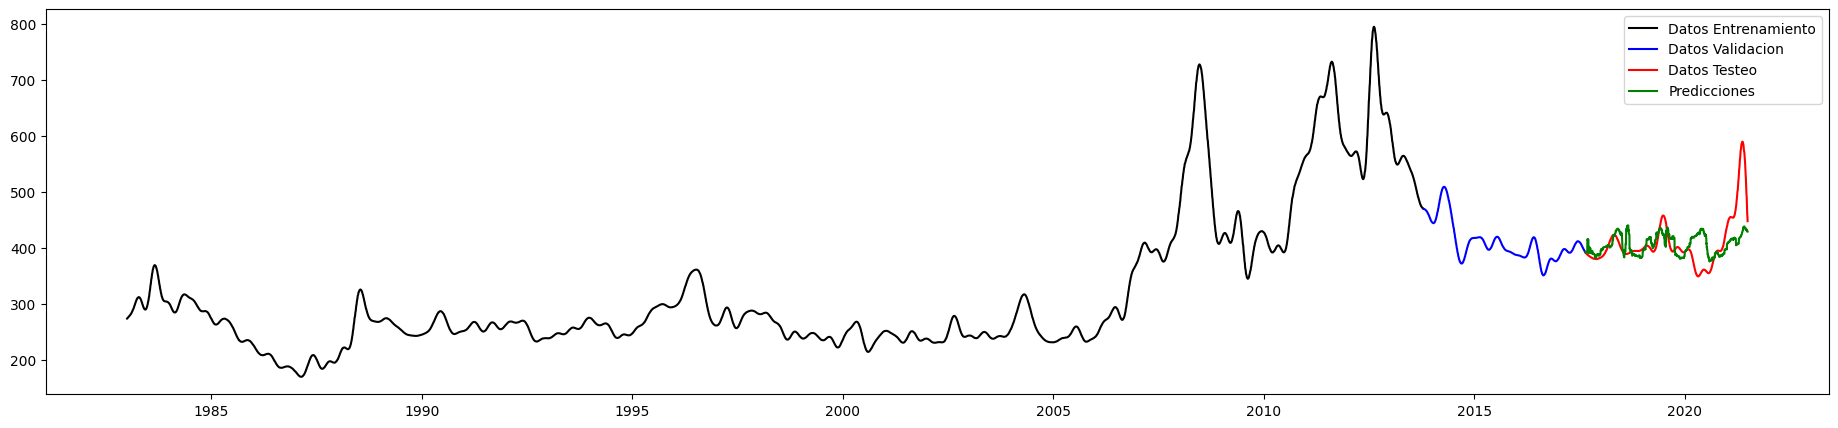

In [ ]:
fig, ax = plt.subplots(figsize=(23, 5))
ax.plot(datos_entrenamiento.index,datos_entrenamiento.Precio_Cierre,color='black',label = 'Datos Entrenamiento')
ax.plot(datos_validacion.index,datos_validacion.Precio_Cierre,color='blue',label = 'Datos Validacion')
ax.plot(datos_testeo.index,datos_testeo.Precio_Cierre,color='red',label = 'Datos Testeo')
ax.plot(datos_testeo.index,y_pred,color='Green',label = 'Predicciones')
ax.legend(loc = 'upper right')
plt.show()

# Modelo VMD
 Vamos a probrar el modelo con los datos obtenidos de la descompocision mediante VMD

In [ ]:
datos_vmd = pd.read_csv("/content/drive/MyDrive/prediccion_productos_agro/SSA_datos.csv")
datos_vmd["Fecha"] = pd.to_datetime(datos_vmd["Fecha"],format='%Y-%m-%d')
datos_vmd.set_index("Fecha", inplace=True)
datos_vmd.head(5)

,Precio_Cierre
Fecha,
2021-06-29,534.439620
2021-06-28,539.981737
2021-06-25,544.759689
2021-06-24,551.242349
2021-06-23,558.255847


In [ ]:
datos_vmd = datos_vmd.asfreq('D')
datos_vmd.interpolate(inplace=True)

<Axes: xlabel='Fecha'>

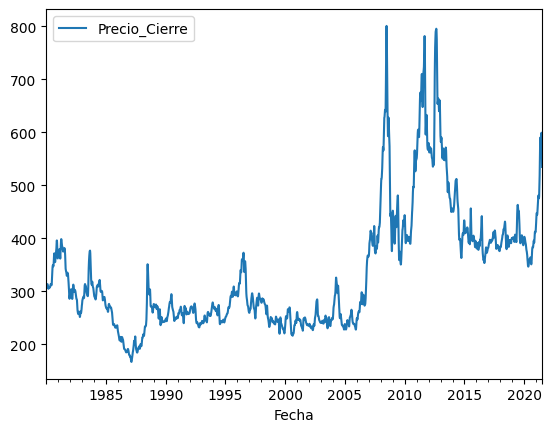

In [ ]:
datos_vmd.plot()

In [ ]:
datos_vmd = create_features(datos_vmd)
datos_vmd = add_lags(datos_vmd)

In [ ]:
datos_vmd.head()

,Precio_Cierre,diasemana,trimestre,mes,año,diadelaño,diadelmes,semanadelaño,lag1,lag2,lag3
Fecha,,,,,,,,,,,
1980-01-02,308.501433,2,1,1,1980,2,2,1,NaN,NaN,NaN
1980-01-03,307.754296,3,1,1,1980,3,3,1,NaN,NaN,NaN
1980-01-04,306.973887,4,1,1,1980,4,4,1,NaN,NaN,NaN
1980-01-05,306.823206,5,1,1,1980,5,5,1,NaN,NaN,NaN
1980-01-06,306.672525,6,1,1,1980,6,6,1,NaN,NaN,NaN


In [ ]:
datos_vmd = datos_vmd.dropna()
datos_vmd.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 14060 entries, 1983-01-01 to 2021-06-29
Freq: D
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Precio_Cierre  14060 non-null  float64
 1   diasemana      14060 non-null  int64  
 2   trimestre      14060 non-null  int64  
 3   mes            14060 non-null  int64  
 4   año            14060 non-null  int64  
 5   diadelaño      14060 non-null  int64  
 6   diadelmes      14060 non-null  int64  
 7   semanadelaño   14060 non-null  UInt32 
 8   lag1           14060 non-null  float64
 9   lag2           14060 non-null  float64
 10  lag3           14060 non-null  float64
dtypes: UInt32(1), float64(4), int64(6)
memory usage: 1.2 MB


In [ ]:
total_datos=len(datos_vmd.Precio_Cierre)
porcentaje_entrenamiento, porcentaje_validacion = 0.8,0.1
division_entrenamiento = int(total_datos*porcentaje_entrenamiento)
division_validacion = division_entrenamiento + int(porcentaje_validacion*total_datos)
print(division_validacion)
print(division_entrenamiento,division_validacion)

datos_entrenamiento = datos_vmd[:division_entrenamiento]
datos_validacion = datos_vmd[division_entrenamiento:division_validacion]
datos_testeo = datos_vmd[division_validacion:total_datos]

12654
11248 12654


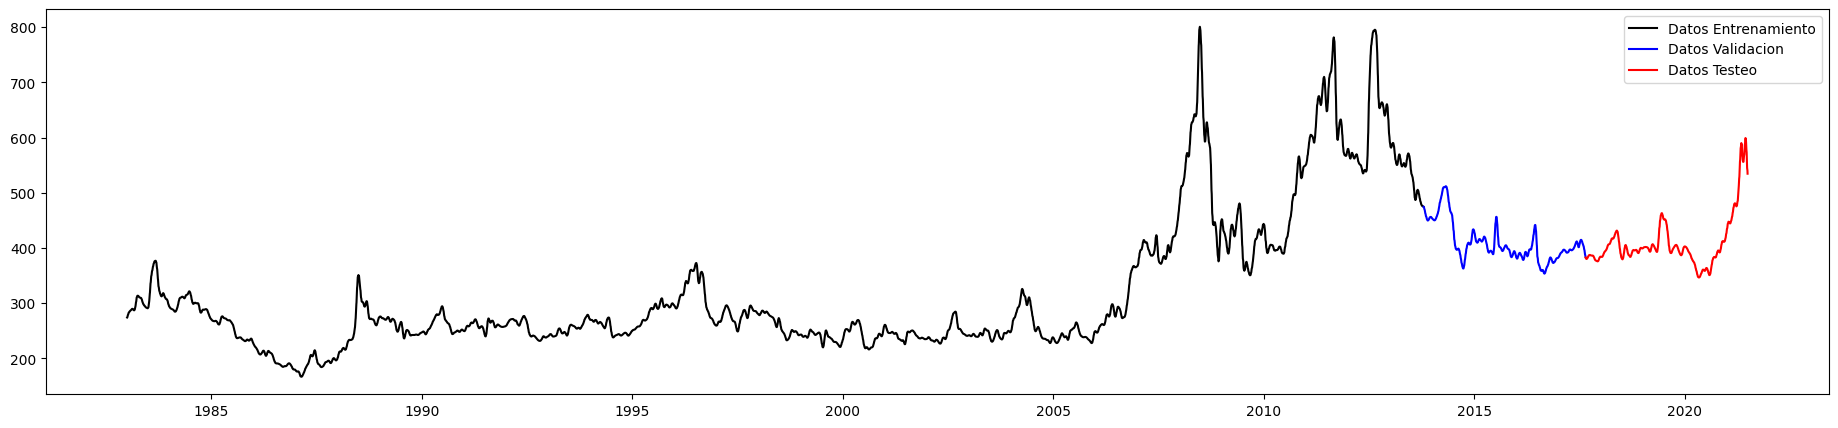

In [ ]:
fig, ax = plt.subplots(figsize=(23, 5))
ax.plot(datos_entrenamiento.index,datos_entrenamiento.Precio_Cierre,color='black',label = 'Datos Entrenamiento')
ax.plot(datos_validacion.index,datos_validacion.Precio_Cierre,color='blue',label = 'Datos Validacion')
ax.plot(datos_testeo.index,datos_testeo.Precio_Cierre,color='red',label = 'Datos Testeo')
ax.legend(loc = 'upper right')
plt.show()

In [ ]:
#ejecutando el modelo de aprendizaje automático
tss = TimeSeriesSplit(n_splits= 3 , test_size= 365 , gap= 1 )
datos_vmd = datos_vmd.sort_index()


fold = 0
preds = []
puntuaciones = []
puntuaciones = []
mapes = []
maes =[]
for train_idx, val_idx in tss.split(datos_vmd[:division_validacion]) :
    train = datos_vmd.iloc[train_idx]
    test = datos_vmd.iloc[val_idx]

    train = create_features(train)
    test = create_features(test)

    CARACTERISTICAS = [ 'diasemana' , 'trimestre' , 'mes' , 'año' ,'diadelaño','diadelmes','semanadelaño',
                'lag1' , 'lag2' , 'lag3' ]
    OBJETIVO = 'Precio_Cierre'

    X_train = train[CARACTERISTICAS]
    y_train = train[OBJETIVO]

    X_test = test[CARACTERISTICAS]
    y_test = test[OBJETIVO]

    reg = xgb.XGBRegressor( base_score= None, booster= None ,
                           n_estimators= 1000 ,
                           early_stopping_rounds= 50 ,
                           Objective= 'reg:squarederror' ,
                           max_depth= 3 ,
                           learning_rate= 0.1 )
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)

    y_pred = reg.predict(X_test)
    y_pred = pd.Series(y_pred)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_pred,y_test))
    puntuaciones.append(score)
    mape = mean_absolute_percentage_error(y_pred,y_test)
    puntuaciones.append(score)
    mapes.append(mape)
    maes.append(mae)

rendimiento["VMD"] = {"RECM":np.mean(puntuaciones),
 "EAM":np.mean(maes) ,
 "PEAM":np.mean(mapes)}


#imprimir puntuaciones para cada pliegue
print ( f'Puntuación entre pliegues {np.mean(puntuaciones)} ' )
print ( f'Puntuaciones plegar: {puntuaciones} ' )

[0]	validation_0-rmse:114.40904	validation_1-rmse:70.86096
[55]	validation_0-rmse:22.88663	validation_1-rmse:71.87436
[0]	validation_0-rmse:113.61530	validation_1-rmse:57.21747
[55]	validation_0-rmse:24.18171	validation_1-rmse:70.19722
[0]	validation_0-rmse:112.61987	validation_1-rmse:59.04735


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [15:19:50] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "Objective" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [15:19:51] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "Objective" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [15:19:51] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "Objective" } are not used.

  warnings.warn(smsg, UserWarning)


[59]	validation_0-rmse:23.39854	validation_1-rmse:20.42900
Puntuación entre pliegues 16.76324129924983 
Puntuaciones plegar: [19.242829014835177, 19.242829014835177, 17.152172400945854, 17.152172400945854, 13.894722481968452, 13.894722481968452] 


In [ ]:
CARACTERISTICAS =[ 'diasemana' , 'trimestre' , 'mes' , 'año' ,'diadelaño','diadelmes','semanadelaño',
                'lag1' , 'lag2' , 'lag3' ]
OBJETIVO = 'Precio_Cierre'

X_train=datos_vmd[CARACTERISTICAS][:division_validacion]
y_train = datos_vmd[OBJETIVO][:division_validacion]

reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)


y_pred = reg.predict(datos_testeo[CARACTERISTICAS])
score = np.sqrt(mean_squared_error(datos_testeo[OBJETIVO],y_pred))

print(f"El error Cuadratico medio del modelo es {score}")


[0]	validation_0-rmse:111.43525	validation_1-rmse:57.74198
[100]	validation_0-rmse:18.39355	validation_1-rmse:6.02547
[200]	validation_0-rmse:13.54603	validation_1-rmse:4.65807


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [15:19:51] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "Objective" } are not used.

  warnings.warn(smsg, UserWarning)


[300]	validation_0-rmse:11.48295	validation_1-rmse:4.35819
[400]	validation_0-rmse:9.96078	validation_1-rmse:4.21779
[500]	validation_0-rmse:8.96004	validation_1-rmse:3.84885
[600]	validation_0-rmse:8.01853	validation_1-rmse:3.90102
[700]	validation_0-rmse:7.32968	validation_1-rmse:3.77648
[800]	validation_0-rmse:6.87913	validation_1-rmse:3.37076
[900]	validation_0-rmse:6.42976	validation_1-rmse:3.29882
[904]	validation_0-rmse:6.40451	validation_1-rmse:3.29617
El error Cuadratico medio del modelo es 43.781168516056525


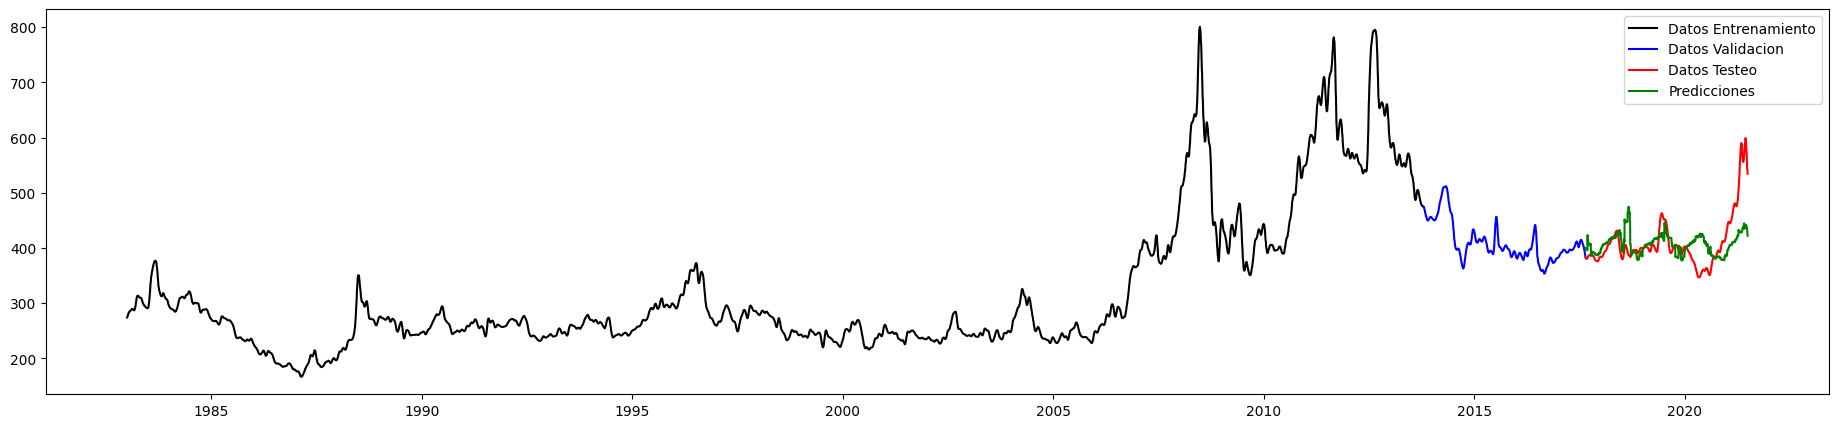

In [ ]:
fig, ax = plt.subplots(figsize=(23, 5))
ax.plot(datos_entrenamiento.index,datos_entrenamiento.Precio_Cierre,color='black',label = 'Datos Entrenamiento')
ax.plot(datos_validacion.index,datos_validacion.Precio_Cierre,color='blue',label = 'Datos Validacion')
ax.plot(datos_testeo.index,datos_testeo.Precio_Cierre,color='red',label = 'Datos Testeo')
ax.plot(datos_testeo.index,y_pred,color='Green',label = 'Predicciones')
ax.legend(loc = 'upper right')
plt.show()

# Modelo SSA

Vamos a probar nuestro modelo con los datos obtenidos de la descomposocion mediante SSA

In [ ]:
datos_ssa = pd.read_csv("/content/drive/MyDrive/prediccion_productos_agro/SSA_datos.csv")
datos_ssa["Fecha"] = pd.to_datetime(datos_ssa["Fecha"],format='%Y-%m-%d')
datos_ssa.set_index("Fecha", inplace=True)
datos_ssa.head(5)

,Precio_Cierre
Fecha,
2021-06-29,534.439620
2021-06-28,539.981737
2021-06-25,544.759689
2021-06-24,551.242349
2021-06-23,558.255847


In [ ]:
datos_ssa = datos_ssa.asfreq('D')
datos_ssa.interpolate(inplace=True)

<Axes: xlabel='Fecha'>

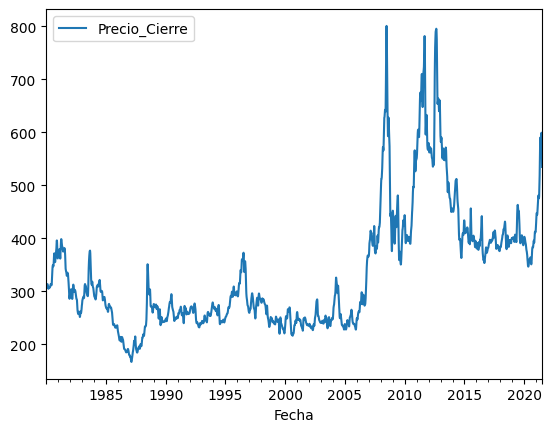

In [ ]:
datos_ssa.plot()

In [ ]:
datos_ssa = create_features(datos_ssa)
datos_ssa = add_lags(datos_ssa)

In [ ]:
datos_ssa.head(5)

,Precio_Cierre,diasemana,trimestre,mes,año,diadelaño,diadelmes,semanadelaño,lag1,lag2,lag3
Fecha,,,,,,,,,,,
1980-01-02,308.501433,2,1,1,1980,2,2,1,NaN,NaN,NaN
1980-01-03,307.754296,3,1,1,1980,3,3,1,NaN,NaN,NaN
1980-01-04,306.973887,4,1,1,1980,4,4,1,NaN,NaN,NaN
1980-01-05,306.823206,5,1,1,1980,5,5,1,NaN,NaN,NaN
1980-01-06,306.672525,6,1,1,1980,6,6,1,NaN,NaN,NaN


In [ ]:
datos_ssa = datos_ssa.dropna()
datos_ssa.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 14060 entries, 1983-01-01 to 2021-06-29
Freq: D
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Precio_Cierre  14060 non-null  float64
 1   diasemana      14060 non-null  int64  
 2   trimestre      14060 non-null  int64  
 3   mes            14060 non-null  int64  
 4   año            14060 non-null  int64  
 5   diadelaño      14060 non-null  int64  
 6   diadelmes      14060 non-null  int64  
 7   semanadelaño   14060 non-null  UInt32 
 8   lag1           14060 non-null  float64
 9   lag2           14060 non-null  float64
 10  lag3           14060 non-null  float64
dtypes: UInt32(1), float64(4), int64(6)
memory usage: 1.2 MB


In [ ]:
total_datos=len(datos_ssa.Precio_Cierre)
porcentaje_entrenamiento, porcentaje_validacion = 0.8,0.1
division_entrenamiento = int(total_datos*porcentaje_entrenamiento)
division_validacion = division_entrenamiento + int(porcentaje_validacion*total_datos)

datos_entrenamiento = datos_ssa[:division_entrenamiento]
datos_validacion = datos_ssa[division_entrenamiento:division_validacion]
datos_testeo = datos_ssa[division_validacion:total_datos]

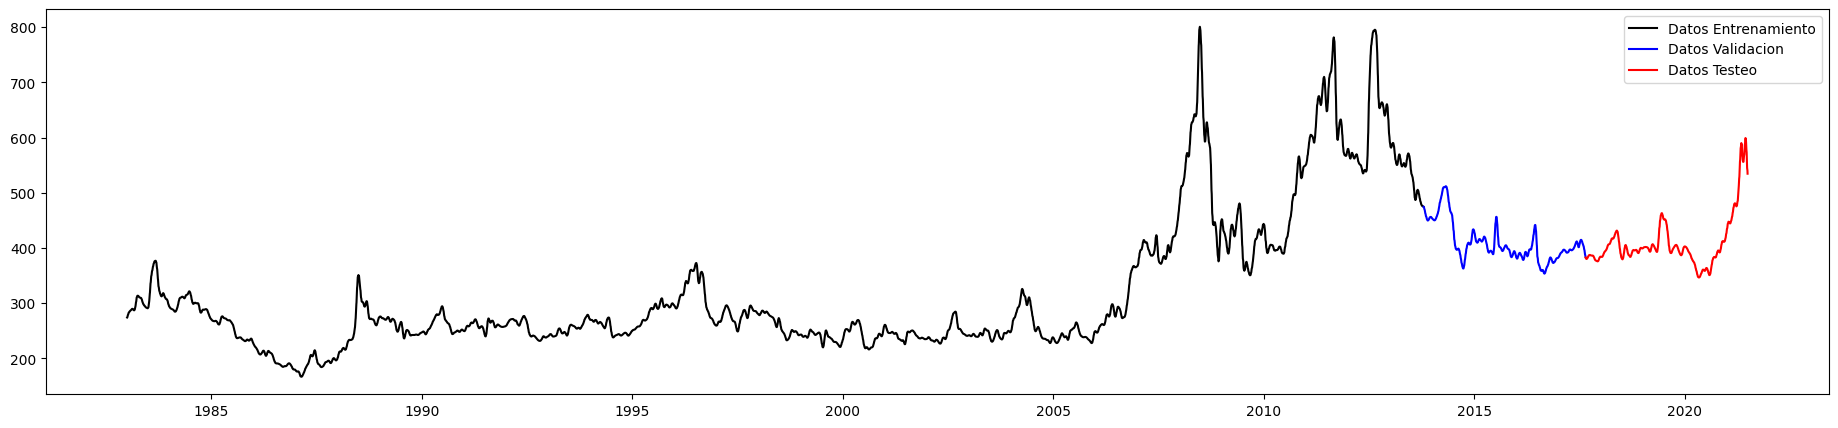

In [ ]:
fig, ax = plt.subplots(figsize=(23, 5))
ax.plot(datos_entrenamiento.index,datos_entrenamiento.Precio_Cierre,color='black',label = 'Datos Entrenamiento')
ax.plot(datos_validacion.index,datos_validacion.Precio_Cierre,color='blue',label = 'Datos Validacion')
ax.plot(datos_testeo.index,datos_testeo.Precio_Cierre,color='red',label = 'Datos Testeo')
ax.legend(loc = 'upper right')
plt.show()

In [ ]:
#ejecutando el modelo de aprendizaje automático
tss = TimeSeriesSplit(n_splits= 3 , test_size= 365 , gap= 1 )
datos_ssa = datos_ssa.sort_index()


fold = 0
puntuaciones = []
puntuaciones = []
mapes = []
maes =[]
for train_idx, val_idx in tss.split(datos_ssa[:division_validacion]) :
    train = datos_ssa.iloc[train_idx]
    test = datos_ssa.iloc[val_idx]

    train = create_features(train)
    test = create_features(test)

    CARACTERISTICAS = [ 'diasemana' , 'trimestre' , 'mes' , 'año' ,'diadelaño','diadelmes','semanadelaño',
                'lag1' , 'lag2' , 'lag3' ]
    OBJETIVO = 'Precio_Cierre'

    X_train = train[CARACTERISTICAS]
    y_train = train[OBJETIVO]

    X_test = test[CARACTERISTICAS]
    y_test = test[OBJETIVO]

    reg = xgb.XGBRegressor( base_score= None, booster= None ,
                           n_estimators= 1000 ,
                           early_stopping_rounds= 50 ,
                           Objective= 'reg:squarederror' ,
                           max_depth= 3 ,
                           learning_rate= 0.1 )
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)

    y_pred = reg.predict(X_test)
    y_pred = pd.Series(y_pred)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_pred,y_test))
    puntuaciones.append(score)
    mape = mean_absolute_percentage_error(y_pred,y_test)
    puntuaciones.append(score)
    mapes.append(mape)
    maes.append(mae)

rendimiento["SSA"] = {"RECM":np.mean(puntuaciones),
 "EAM":np.mean(maes) ,
 "PEAM":np.mean(mapes)}

#imprimir puntuaciones para cada pliegue
print ( f'Puntuación entre pliegues {np.mean(puntuaciones)} ' )
print ( f'Puntuaciones plegar: {puntuaciones} ' )

[0]	validation_0-rmse:114.40904	validation_1-rmse:70.86096


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [15:19:53] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "Objective" } are not used.

  warnings.warn(smsg, UserWarning)


[55]	validation_0-rmse:22.88663	validation_1-rmse:71.87436
[0]	validation_0-rmse:113.61530	validation_1-rmse:57.21747
[55]	validation_0-rmse:24.18171	validation_1-rmse:70.19722
[0]	validation_0-rmse:112.61987	validation_1-rmse:59.04735
[58]	validation_0-rmse:23.50883	validation_1-rmse:20.41522
Puntuación entre pliegues 16.76324129924983 
Puntuaciones plegar: [19.242829014835177, 19.242829014835177, 17.152172400945854, 17.152172400945854, 13.894722481968452, 13.894722481968452] 


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [15:19:54] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "Objective" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [15:19:54] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "Objective" } are not used.

  warnings.warn(smsg, UserWarning)


In [ ]:
CARACTERISTICAS =[ 'diasemana' , 'trimestre' , 'mes' , 'año' ,'diadelaño','diadelmes','semanadelaño',
                'lag1' , 'lag2' , 'lag3' ]
OBJETIVO = 'Precio_Cierre'

X_train=datos_ssa[CARACTERISTICAS][:division_validacion]
y_train = datos_ssa[OBJETIVO][:division_validacion]

reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)


y_pred = reg.predict(datos_testeo[CARACTERISTICAS])
score = np.sqrt(mean_squared_error(datos_testeo[OBJETIVO],y_pred))

print(f"El error Cuadratico medio del modelo es {score}")


[0]	validation_0-rmse:111.43525	validation_1-rmse:57.74198
[100]	validation_0-rmse:18.39355	validation_1-rmse:6.02547


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [15:19:54] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "Objective" } are not used.

  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:13.54603	validation_1-rmse:4.65807
[300]	validation_0-rmse:11.48295	validation_1-rmse:4.35819
[400]	validation_0-rmse:9.96078	validation_1-rmse:4.21779
[500]	validation_0-rmse:8.96004	validation_1-rmse:3.84885
[600]	validation_0-rmse:8.01853	validation_1-rmse:3.90102
[700]	validation_0-rmse:7.32968	validation_1-rmse:3.77648
[800]	validation_0-rmse:6.87913	validation_1-rmse:3.37076
[900]	validation_0-rmse:6.42976	validation_1-rmse:3.29882
[905]	validation_0-rmse:6.40089	validation_1-rmse:3.29403
El error Cuadratico medio del modelo es 43.781168516056525


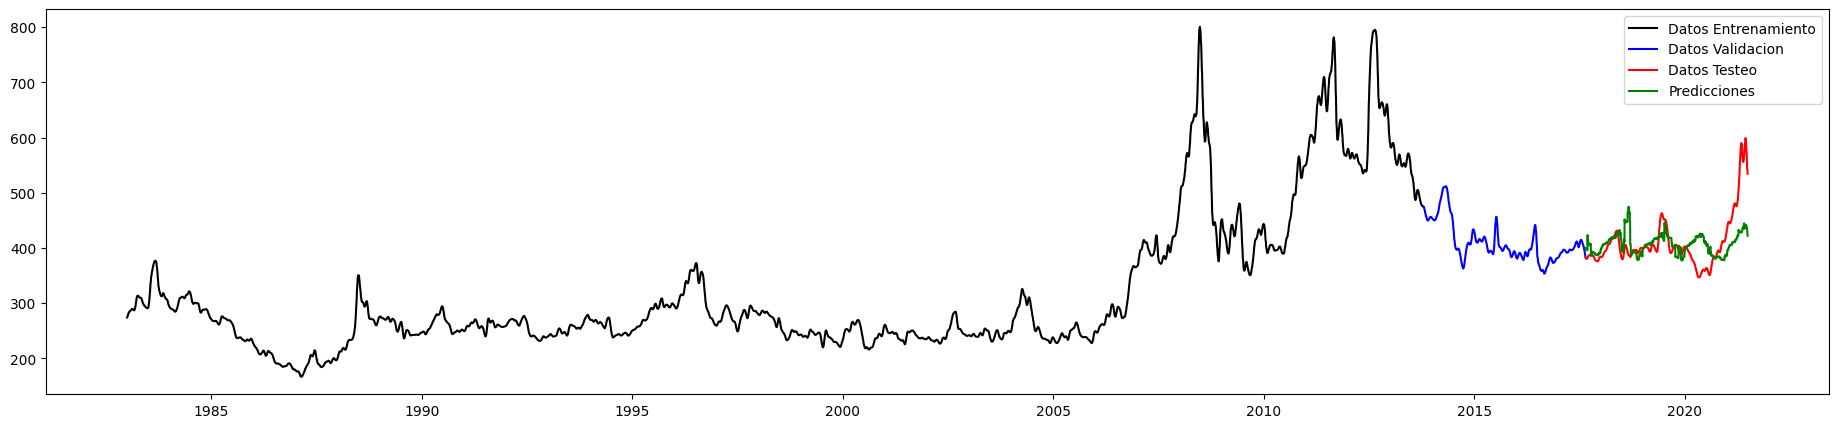

In [ ]:
fig, ax = plt.subplots(figsize=(23, 5))
ax.plot(datos_entrenamiento.index,datos_entrenamiento.Precio_Cierre,color='black',label = 'Datos Entrenamiento')
ax.plot(datos_validacion.index,datos_validacion.Precio_Cierre,color='blue',label = 'Datos Validacion')
ax.plot(datos_testeo.index,datos_testeo.Precio_Cierre,color='red',label = 'Datos Testeo')
ax.plot(datos_testeo.index,y_pred,color='Green',label = 'Predicciones')
ax.legend(loc = 'upper right')
plt.show()

# Modelo EMD
Vamos a probar nuestro modelo con los datos obtenidos de la descomposocion mediante EMD

In [ ]:
datos_emd = pd.read_csv("/content/drive/MyDrive/prediccion_productos_agro/EMD_datos.csv")
datos_emd["Fecha"] = pd.to_datetime(datos_emd["Fecha"],format='%Y-%m-%d')
datos_emd.set_index("Fecha", inplace=True)
datos_emd.head(5)

,Precio_Cierre
Fecha,
2021-06-29,517.647541
2021-06-28,517.640351
2021-06-25,517.633132
2021-06-24,517.625883
2021-06-23,517.618605


In [ ]:
datos_emd = datos_emd.asfreq('D')
datos_emd.interpolate(inplace=True)

<Axes: xlabel='Fecha'>

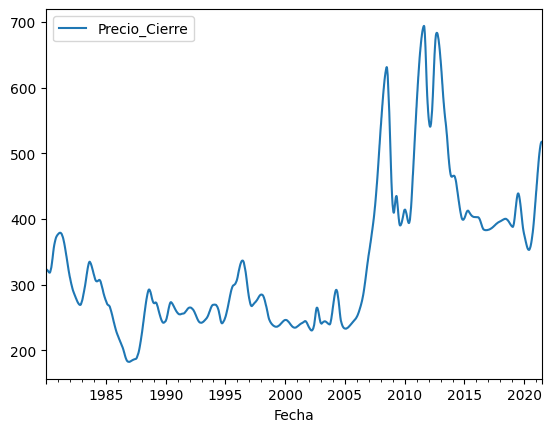

In [ ]:
datos_emd.plot()

In [ ]:
datos_emd = create_features(datos_ssa)
datos_emd = add_lags(datos_ssa)

In [ ]:
datos_emd = datos_emd.dropna()
datos_emd.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 12965 entries, 1985-12-31 to 2021-06-29
Freq: D
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Precio_Cierre  12965 non-null  float64
 1   diasemana      12965 non-null  int64  
 2   trimestre      12965 non-null  int64  
 3   mes            12965 non-null  int64  
 4   año            12965 non-null  int64  
 5   diadelaño      12965 non-null  int64  
 6   diadelmes      12965 non-null  int64  
 7   semanadelaño   12965 non-null  UInt32 
 8   lag1           12965 non-null  float64
 9   lag2           12965 non-null  float64
 10  lag3           12965 non-null  float64
dtypes: UInt32(1), float64(4), int64(6)
memory usage: 1.1 MB


In [ ]:
total_datos=len(datos_emd.Precio_Cierre)
porcentaje_entrenamiento, porcentaje_validacion = 0.8,0.1
division_entrenamiento = int(total_datos*porcentaje_entrenamiento)
division_validacion = division_entrenamiento + int(porcentaje_validacion*total_datos)

datos_entrenamiento = datos_emd[:division_entrenamiento]
datos_validacion = datos_emd[division_entrenamiento:division_validacion]
datos_testeo = datos_emd[division_validacion:total_datos]

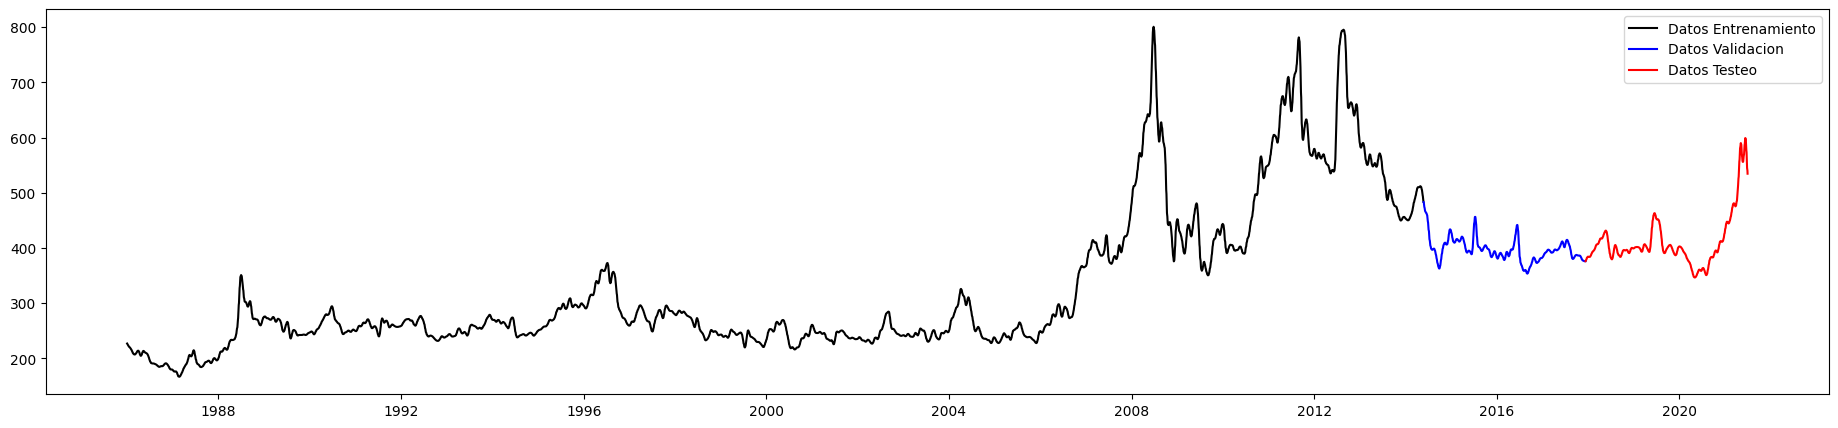

In [ ]:
fig, ax = plt.subplots(figsize=(23, 5))
ax.plot(datos_entrenamiento.index,datos_entrenamiento.Precio_Cierre,color='black',label = 'Datos Entrenamiento')
ax.plot(datos_validacion.index,datos_validacion.Precio_Cierre,color='blue',label = 'Datos Validacion')
ax.plot(datos_testeo.index,datos_testeo.Precio_Cierre,color='red',label = 'Datos Testeo')
ax.legend(loc = 'upper right')
plt.show()

In [ ]:
#ejecutando el modelo de aprendizaje automático
tss = TimeSeriesSplit(n_splits= 3 , test_size= 365 , gap= 1 )
datos_emd = datos_emd.sort_index()


fold = 0
puntuaciones = []
puntuaciones = []
mapes = []
maes =[]
for train_idx, val_idx in tss.split(datos_emd[:division_validacion]) :
    train = datos_emd.iloc[train_idx]
    test = datos_emd.iloc[val_idx]

    train = create_features(train)
    test = create_features(test)

    CARACTERISTICAS = [ 'diasemana' , 'trimestre' , 'mes' , 'año' ,'diadelaño','diadelmes','semanadelaño',
                'lag1' , 'lag2' , 'lag3' ]
    OBJETIVO = 'Precio_Cierre'

    X_train = train[CARACTERISTICAS]
    y_train = train[OBJETIVO]

    X_test = test[CARACTERISTICAS]
    y_test = test[OBJETIVO]

    reg = xgb.XGBRegressor( base_score= None, booster= None ,
                           n_estimators= 1000 ,
                           early_stopping_rounds= 50 ,
                           Objective= 'reg:squarederror' ,
                           max_depth= 3 ,
                           learning_rate= 0.1 )
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)

    y_pred = reg.predict(X_test)
    y_pred = pd.Series(y_pred)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_pred,y_test))
    mape = mean_absolute_percentage_error(y_pred,y_test)
    puntuaciones.append(score)
    mapes.append(mape)
    maes.append(mae)

rendimiento["EMD"] = {"RECM":np.mean(puntuaciones),
 "EAM":np.mean(maes) ,
 "PEAM":np.mean(mapes)}

#imprimir puntuaciones para cada pliegue
print ( f'Puntuación entre pliegues {np.mean(puntuaciones)} ' )
print ( f'Puntuaciones plegar: {puntuaciones} ' )

[0]	validation_0-rmse:118.98249	validation_1-rmse:69.38237
[54]	validation_0-rmse:23.44220	validation_1-rmse:75.19852
[0]	validation_0-rmse:118.03775	validation_1-rmse:53.09829
[55]	validation_0-rmse:23.28909	validation_1-rmse:36.83606
[0]	validation_0-rmse:116.52948	validation_1-rmse:58.21983


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [15:19:57] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "Objective" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [15:19:57] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "Objective" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [15:19:57] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "Objective" } are not used.

  warnings.warn(smsg, UserWarning)


[61]	validation_0-rmse:22.44058	validation_1-rmse:18.33872
Puntuación entre pliegues 16.285981511475235 
Puntuaciones plegar: [18.94430079270404, 19.434549968922745, 10.47909377279892] 


In [ ]:
CARACTERISTICAS =[ 'diasemana' , 'trimestre' , 'mes' , 'año' ,'diadelaño','diadelmes','semanadelaño',
                'lag1' , 'lag2' , 'lag3' ]
OBJETIVO = 'Precio_Cierre'

X_train=datos_emd[CARACTERISTICAS][:division_validacion]
y_train = datos_emd[OBJETIVO][:division_validacion]

reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)


y_pred = reg.predict(datos_testeo[CARACTERISTICAS])
score = np.sqrt(mean_squared_error(datos_testeo[OBJETIVO],y_pred))

print(f"El error Cuadratico medio del modelo es {score}")

[0]	validation_0-rmse:115.13981	validation_1-rmse:56.52337
[100]	validation_0-rmse:18.28950	validation_1-rmse:5.61342
[185]	validation_0-rmse:14.26896	validation_1-rmse:4.95793


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [15:19:57] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "Objective" } are not used.

  warnings.warn(smsg, UserWarning)


El error Cuadratico medio del modelo es 52.17284927279407


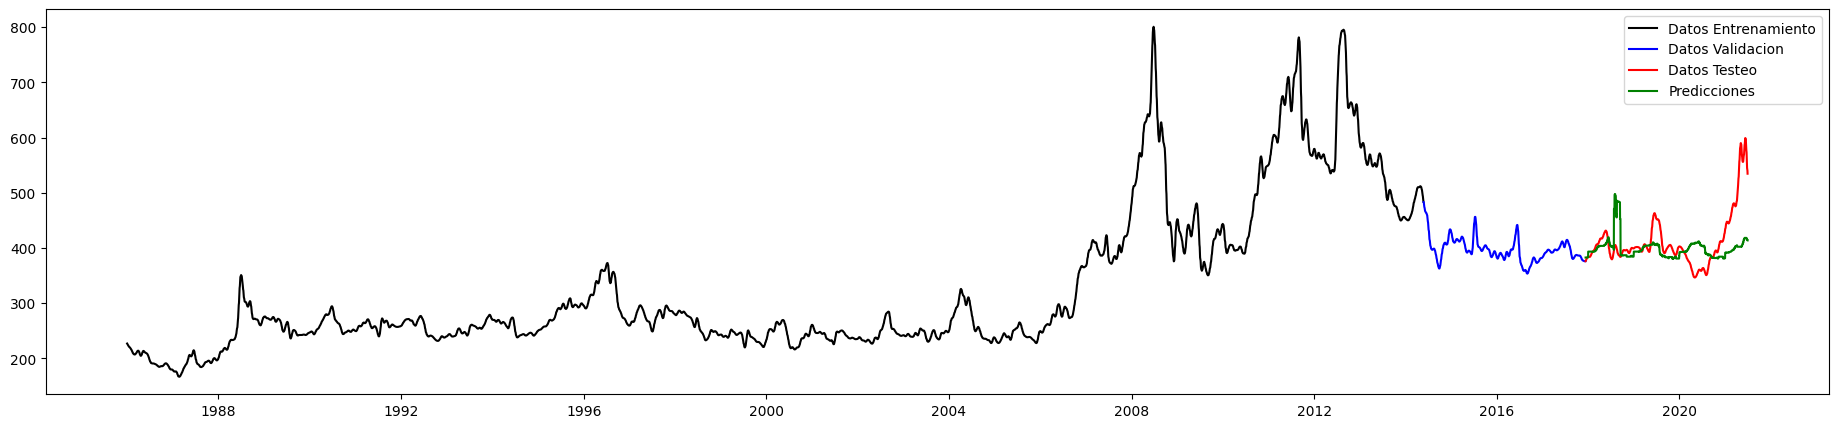

In [ ]:
fig, ax = plt.subplots(figsize=(23, 5))
ax.plot(datos_entrenamiento.index,datos_entrenamiento.Precio_Cierre,color='black',label = 'Datos Entrenamiento')
ax.plot(datos_validacion.index,datos_validacion.Precio_Cierre,color='blue',label = 'Datos Validacion')
ax.plot(datos_testeo.index,datos_testeo.Precio_Cierre,color='red',label = 'Datos Testeo')
ax.plot(datos_testeo.index,y_pred,color='Green',label = 'Predicciones')
ax.legend(loc = 'upper right')
plt.show()

In [ ]:
pd.DataFrame.from_dict(rendimiento, orient='index')

,RECM,EAM,PEAM
EWT,15.526074,12.769687,0.032879
VMD,16.763241,11.284562,0.032427
SSA,16.763241,11.284562,0.032427
EMD,16.285982,11.284562,0.032929
